In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2class - cigarette / vape

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/프로그래머스/3차프로젝트/2class'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 이미지 데이터 제너레이터 설정
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

Found 12030 images belonging to 2 classes.
Found 1156 images belonging to 2 classes.
Found 561 images belonging to 2 classes.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)           5919312   ['input_13[0][0]']            
 nal)                                                                                             
                                                                                                  
 resnet50v2 (Functional)     (None, 7, 7, 2048)           2356480   ['input_13[0][0]']            
                                                          0                                       
                                                                                            

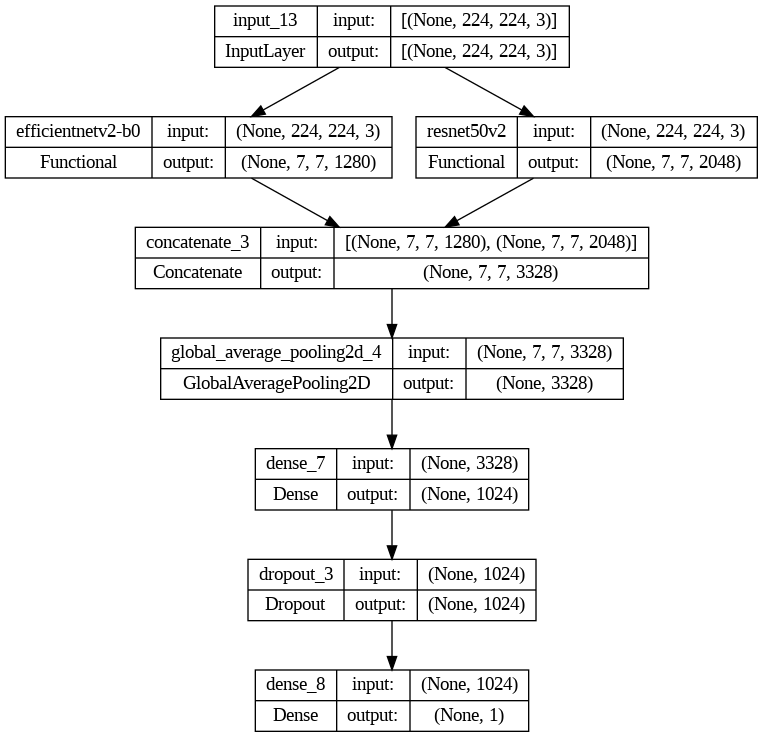

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models

def build_combined_model(input_shape=(224, 224, 3)):
    # EfficientNetV2의 기본 블록 가져오기
    efficientnet_base = tf.keras.applications.EfficientNetV2B0(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # ResNet50V2의 기본 블록 가져오기
    resnet_base = tf.keras.applications.ResNet50V2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # 공통 입력 레이어 정의
    input_layer = tf.keras.Input(shape=input_shape)

    # EfficientNetV2와 ResNet50V2에 공통 입력 전달
    efficientnet_output = efficientnet_base(input_layer)
    resnet_output = resnet_base(input_layer)

    # 두 출력을 결합
    combined = layers.Concatenate()([efficientnet_output, resnet_output])

    # 결합된 출력을 Global Average Pooling
    x = layers.GlobalAveragePooling2D()(combined)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # 최종 모델 생성 (입력 레이어 명시)
    model = models.Model(inputs=input_layer, outputs=outputs)

    # EfficientNetV2와 ResNet50V2의 레이어를 동결
    for layer in efficientnet_base.layers:
        layer.trainable = False

    for layer in resnet_base.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 모델 생성
model = build_combined_model()

# 모델 요약 출력
model.summary()

# 모델 구조를 이미지로 저장
plot_model(model, to_file='hybrid_model(EfficientNetV2 + ResNet50V2).png', show_shapes=True, show_layer_names=True)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표
    patience=5,         # 개선되지 않더라도 기다리는 에포크 수
    min_delta=0.001,     # 성능 향상으로 간주할 최소 변화량
    restore_best_weights=True,  # 성능이 가장 좋았던 가중치 복원
    mode='min'           # 'val_loss'는 최소화를 목표로 함
)
#***경로 변경***
model_name = 'hybrid_(EfficientNetV2 + ResNet50V2)'
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/'+model_name,
                          monitor='val_loss',
                          save_best_only=True)

# 모델 학습
history = model.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks = [checkpoint,early_stopping])

Epoch 1/50
376/376 [==============================] - 3439s 9s/step - loss: 0.2742 - accuracy: 0.8951 - val_loss: 0.2793 - val_accuracy: 0.8754
Epoch 2/50
376/376 [==============================] - 3145s 8s/step - loss: 0.1547 - accuracy: 0.9374 - val_loss: 0.2341 - val_accuracy: 0.9048
Epoch 3/50
376/376 [==============================] - 3009s 8s/step - loss: 0.1240 - accuracy: 0.9505 - val_loss: 0.2580 - val_accuracy: 0.8893
Epoch 4/50
376/376 [==============================] - 2990s 8s/step - loss: 0.0974 - accuracy: 0.9635 - val_loss: 0.2531 - val_accuracy: 0.9161
Epoch 5/50
376/376 [==============================] - 2977s 8s/step - loss: 0.0700 - accuracy: 0.9746 - val_loss: 0.3813 - val_accuracy: 0.8754
Epoch 6/50
376/376 [==============================] - 2977s 8s/step - loss: 0.0611 - accuracy: 0.9775 - val_loss: 0.2768 - val_accuracy: 0.9083
Epoch 7/50
376/376 [==============================] - 2991s 8s/step - loss: 0.0627 - accuracy: 0.9752 - val_loss: 0.3040 - val_accuracy:

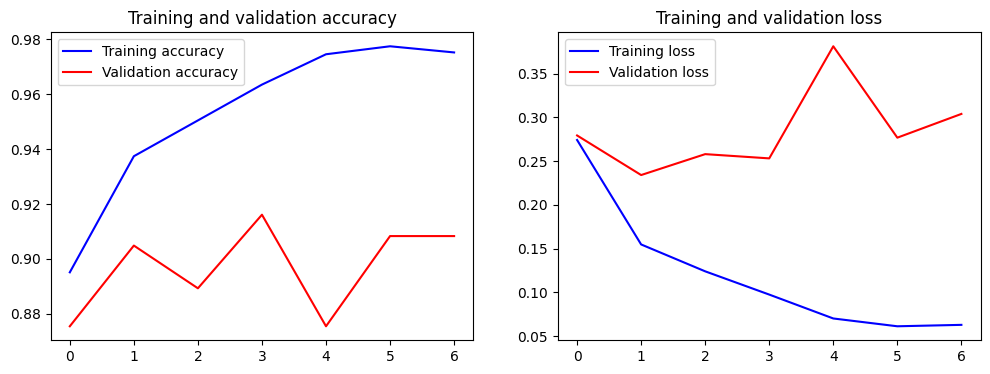

18/18 [==============================] - 146s 8s/step - loss: 0.2472 - accuracy: 0.9037
Test Accuracy: 0.903743326663971
18/18 [==============================] - 128s 7s/step


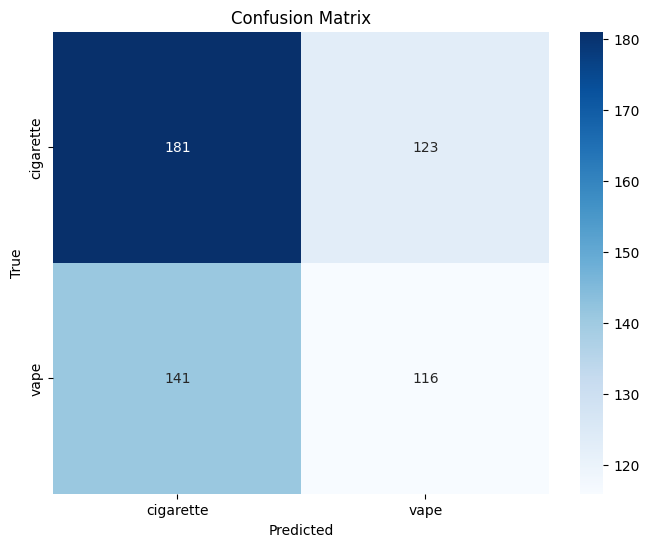

              precision    recall  f1-score   support

   cigarette       0.56      0.60      0.58       304
        vape       0.49      0.45      0.47       257

    accuracy                           0.53       561
   macro avg       0.52      0.52      0.52       561
weighted avg       0.53      0.53      0.53       561



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import time

# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

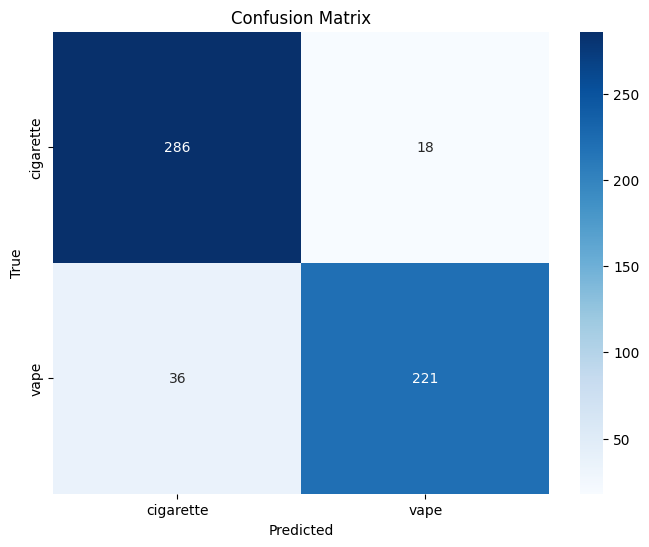

              precision    recall  f1-score   support

   cigarette       0.89      0.94      0.91       304
        vape       0.92      0.86      0.89       257

    accuracy                           0.90       561
   macro avg       0.91      0.90      0.90       561
weighted avg       0.90      0.90      0.90       561



In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# # 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/프로그래머스/3차프로젝트/2class'
test_dir = os.path.join(base_dir, 'test')

# 데이터 로드
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

# 저장된 모델 불러오기

model_path = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/hybrid_(EfficientNetV2 + ResNet50V2)'
model = tf.keras.models.load_model(model_path)

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()  # 임계값 0.5로 이진화

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)

{'cigarette': 0, 'vape': 1}
{0: 'cigarette', 1: 'vape'}


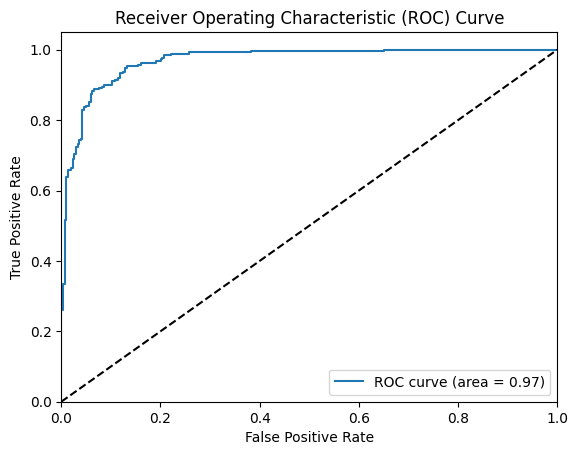

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 클래스 인덱스 확인
class_indices = test_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 예측 확률 값 얻기
# y_pred_prob = model.predict(test_generator)
y_pred_prob = Y_pred
# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = test_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()